# Нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.

<b>Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.</b>

В данных:

- <b>submission_data_test.csv</b>

- <b>events_data_test.csv</b>

хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019. 

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе. 

## Описание данных:

<b>events_train.csv</b> - данные о действиях, которые совершают студенты со стэпами

1. step_id - id стэпа
2. user_id - анонимизированный id юзера
3. timestamp - время наступления события в формате unix date
4. action - событие, возможные значения: 
 - discovered - пользователь перешел на стэп
 - viewed - просмотр шага,
 - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
 - passed - удачное решение практического шага

<b>submissions_train.csv</b> - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
import pandas as pd
import numpy as np

In [3]:
event_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
event_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
events_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [6]:
submission_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
submission_data_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


# Валидация данных и предобработка данных

In [7]:
events_data_test.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [8]:
events_data_test['action'].unique()

array(['viewed', 'discovered', 'passed', 'started_attempt'], dtype=object)

In [9]:
submission_data_test.dtypes

step_id               int64
timestamp             int64
submission_status    object
user_id               int64
dtype: object

In [10]:
submission_data_test['submission_status'].unique()

array(['wrong', 'correct'], dtype=object)

In [11]:
event_data_train.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [12]:
event_data_train['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [13]:
submissions_data_train['submission_status'].unique()

array(['correct', 'wrong'], dtype=object)

In [14]:
submissions_data_train.dtypes

step_id               int64
timestamp             int64
submission_status    object
user_id               int64
dtype: object

Создадим новые колонки:
   1. колонку, в которой значение из колонки timestamp будет переведено в формат даты.
   2. колонку, в которая будет просто являться днём.

In [15]:
events_data_test['date'] = pd.to_datetime(events_data_test['timestamp'], unit='s')
events_data_test['day'] = events_data_test['date'].dt.date
events_data_test.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [16]:
events_data_test.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

In [17]:
submission_data_test['date'] = pd.to_datetime(submission_data_test['timestamp'], unit='s')
submission_data_test['day'] = submission_data_test['date'].dt.date
submission_data_test.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [18]:
submission_data_test.dtypes

step_id                       int64
timestamp                     int64
submission_status            object
user_id                       int64
date                 datetime64[ns]
day                          object
dtype: object

In [19]:
event_data_train['date'] = pd.to_datetime(event_data_train['timestamp'], unit='s')
event_data_train['day'] = event_data_train['date'].dt.date
event_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [20]:
event_data_train.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

In [21]:
submissions_data_train['date'] = pd.to_datetime(submissions_data_train['timestamp'], unit='s')
submissions_data_train['day'] = submissions_data_train.date.dt.date
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [22]:
submissions_data_train.dtypes

step_id                       int64
timestamp                     int64
submission_status            object
user_id                       int64
date                 datetime64[ns]
day                          object
dtype: object

<b>Теперь мы можем построить график активности студентов за всё время</b>

<AxesSubplot:xlabel='day'>

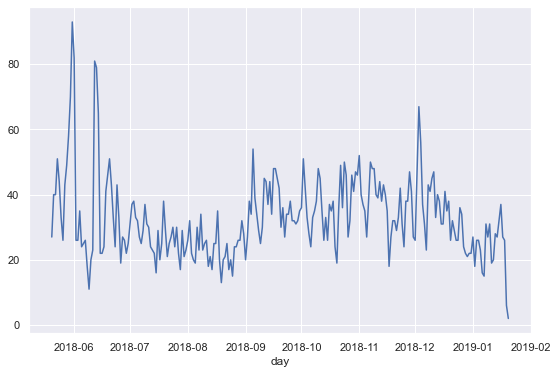

In [23]:
sns.set(rc={'figure.figsize': (9, 6)})
events_data_test.groupby(['day'])['user_id'].nunique().plot()

<AxesSubplot:xlabel='day'>

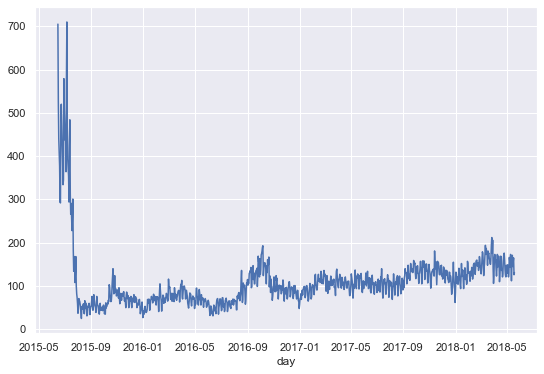

In [24]:
sns.set(rc={'figure.figsize': (9, 6)})
event_data_train.groupby(['day'])['user_id'].nunique().plot()

In [25]:
users_scores = submission_data_test.pivot_table(index='user_id',
                                                        columns='submission_status',
                                                        values='step_id',
                                                        aggfunc='count').fillna(0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,12,1.0,0.0
1,13,29.0,36.0
2,15,10.0,30.0
3,21,24.0,103.0
4,35,7.0,35.0


<AxesSubplot:xlabel='correct', ylabel='Count'>

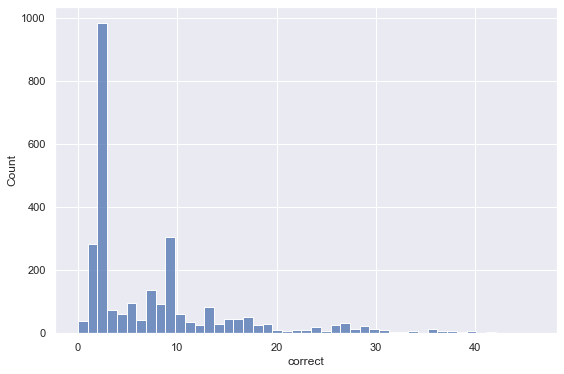

In [26]:
sns.histplot(data=users_scores['correct'])

<AxesSubplot:>

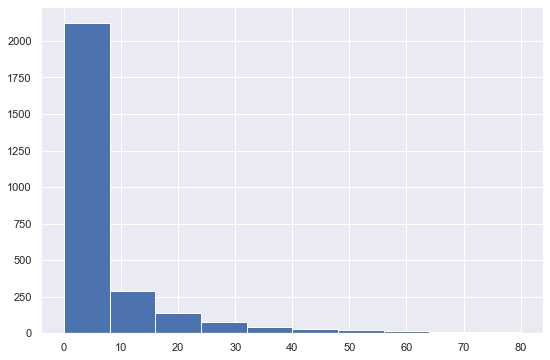

In [27]:
users_scores[users_scores.wrong <= 80]['wrong'].hist()

<AxesSubplot:xlabel='wrong', ylabel='Count'>

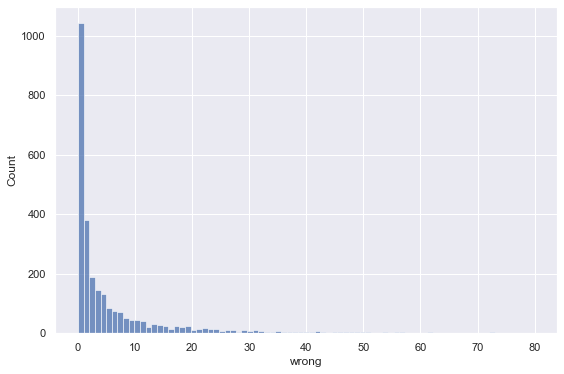

In [28]:
sns.histplot(data=users_scores[users_scores.wrong <= 80]['wrong'])

<b>Только 0.3% пользователей набирают больше 40 баллов за курс за первые два дня</b>

In [29]:
users_scores.correct.quantile(0.997)

40.0

In [30]:
users_scores_all_time = submissions_data_train.pivot_table(index='user_id',
                                                        columns='submission_status',
                                                        values='step_id',
                                                        aggfunc='count').fillna(0).reset_index()
users_scores_all_time.head()

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0


<AxesSubplot:xlabel='correct', ylabel='Count'>

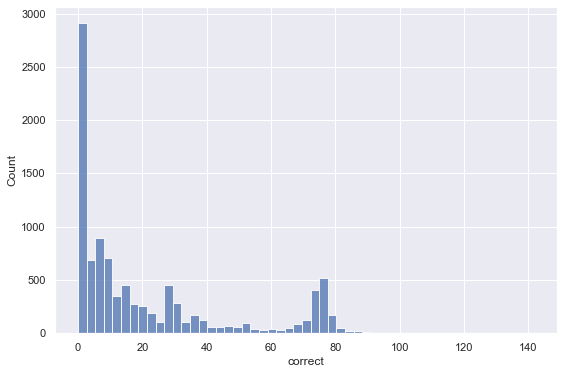

In [31]:
sns.histplot(data=users_scores_all_time[users_scores_all_time.correct <= 150]['correct'])

In [32]:
users_scores_all_time.correct.quantile(0.8)

40.0

<b>За всё время 20% процентов пользователей набрали больше, чем 40 баллов на курсе</b>

In [33]:
# Отберём данные о первых активных действиях пользователя на курсе
user_min_time = event_data_train.groupby('user_id', as_index=False).agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'})
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


Нам теперь нужно для данных, хранящихся в <i>submissions_data_train</i> отобрать для каждого пользователя только события, вписывающиеся в промежуток первых двух дней после начала курса.

Мы не можем сделать фильтрацию только по <i>user_id</i>, нам нужно сложное комбинированное условие по <i>user_id</i> и <i>timestamp</i>. Для каждого <i>user_id</i> границы <i>timestamp</i> разные и как к этому подойти - непонятно.

Давайте создадим в <i>submissions_data_train</i> новую колонку <i>user_time</i>

In [34]:
submissions_data_train['user_time'] = submissions_data_train.user_id.apply(str) + '_' + submissions_data_train.timestamp.apply(str)
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123


In [35]:
learning_time_treshold = 2 * 24 * 60 * 60
user_min_time['user_learning_time_treshold'] = user_min_time.user_id.apply(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).apply(str)
user_min_time.head()

,user_id,min_timestamp,user_learning_time_treshold
0,1,1472827464,1_1473000264
1,2,1514383364,2_1514556164
2,3,1434358476,3_1434531276
3,5,1466156809,5_1466329609
4,7,1521634660,7_1521807460


In [36]:
# Сделаем мёрдж наших данных с датафреймом user_min_time, отобрав из него только нужные нам данные
submissions_data_train = submissions_data_train.merge(user_min_time[['user_id', 'user_learning_time_treshold']], on='user_id', how='outer')
submissions_data_train.shape

(518398, 8)

In [37]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149,15853_1434518777
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777


In [38]:
#  Нам теперь для каждого пользователя достаточно просто узнать - "правда ли, что его время выполнения каждого действия 
# вписыается в нужный нам диапазон?".

# И тут нам на помощь приходит то, что строки можно сравнивать так же как инты
submission_data_two_days = submissions_data_train[submissions_data_train.user_time <= submissions_data_train.user_learning_time_treshold]
submission_data_two_days.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434518777
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434518777


In [39]:
submission_data_two_days.shape

(115466, 8)

In [40]:
submission_data_two_days.groupby('user_id')['day'].nunique().max()

3

In [41]:
# Тоже самое с events_data_test
event_data_train['user_time'] = event_data_train.user_id.apply(str) + '_' + event_data_train.timestamp.apply(str)
event_data_train = event_data_train.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
events_data_two_days = event_data_train[event_data_train.user_time <= event_data_train.user_learning_time_treshold]
events_data_two_days.groupby('user_id').day.nunique().max()

3

In [42]:
X = submission_data_two_days.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={
    'day':'days'
})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2


In [43]:
X_test = submission_data_test.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={
    'day':'days'
})
X_test.head()

,user_id,days
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3


In [44]:
step_tried = submission_data_two_days.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={
    'step_id':'steps_tried'
})
step_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,18


In [45]:
X = X.merge(step_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,2,18


In [46]:
X_test = X_test.merge(submission_data_test.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={
    'step_id':'steps_tried'
}), on='user_id', how='outer')
X_test.head()

,user_id,days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9


In [47]:
users_scores_all_time.head()

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0


In [48]:
X = X.merge(users_scores_all_time, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1.0,2.0,2.0,0.0
1,3,1.0,4.0,29.0,23.0
2,8,1.0,11.0,9.0,21.0
3,14,1.0,1.0,0.0,1.0
4,16,2.0,18.0,77.0,106.0


In [49]:
X_test = X_test.merge(users_scores, on='user_id', how='outer')
X_test.head()

,user_id,days,steps_tried,correct,wrong
0,12,1,1,1.0,0.0
1,13,2,29,29.0,36.0
2,15,3,11,10.0,30.0
3,21,1,30,24.0,103.0
4,35,3,9,7.0,35.0


In [50]:
X.shape

(9940, 5)

In [51]:
X_test.shape

(2803, 5)

In [52]:
X['correction_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio
0,2,1.0,2.0,2.0,0.0,1.000000
1,3,1.0,4.0,29.0,23.0,0.557692
2,8,1.0,11.0,9.0,21.0,0.300000
3,14,1.0,1.0,0.0,1.0,0.000000
4,16,2.0,18.0,77.0,106.0,0.420765


In [53]:
X_test['correction_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)
X_test.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio
0,12,1,1,1.0,0.0,1.000000
1,13,2,29,29.0,36.0,0.446154
2,15,3,11,10.0,30.0,0.250000
3,21,1,30,24.0,103.0,0.188976
4,35,3,9,7.0,35.0,0.166667


In [54]:
viewed_steps_count = events_data_two_days.pivot_table(index='user_id',
                                                    columns='action',
                                                    values='step_id',
                                                    aggfunc='count',
                                                    fill_value=0).reset_index()[['user_id', 'viewed']]
viewed_steps_count.head()

action,user_id,viewed
0,1,1
1,2,9
2,3,20
3,5,1
4,7,1


In [55]:
X = X.merge(viewed_steps_count, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,29.0,23.0,0.557692,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,2.0,18.0,77.0,106.0,0.420765,117


In [56]:
X_test = X_test.merge(events_data_test.pivot_table(index='user_id',
                                                    columns='action',
                                                    values='step_id',
                                                    aggfunc='count',
                                                    fill_value=0).reset_index()[['user_id', 'viewed']], on='user_id', how='outer')
X_test.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed
0,12,1.0,1.0,1.0,0.0,1.000000,14
1,13,2.0,29.0,29.0,36.0,0.446154,105
2,15,3.0,11.0,10.0,30.0,0.250000,1
3,21,1.0,30.0,24.0,103.0,0.188976,98
4,35,3.0,9.0,7.0,35.0,0.166667,70


In [57]:
X.shape

(19234, 7)

In [58]:
X_test.shape

(6184, 7)

In [59]:
X = X.fillna(0)
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)
X.head()

,days,steps_tried,correct,wrong,correction_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,29.0,23.0,0.557692,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,2.0,18.0,77.0,106.0,0.420765,117


In [60]:
X_test = X_test.fillna(0)
X_test = X_test.set_index(X_test.user_id)
X_test = X_test.drop(['user_id'], axis=1)
X_test.head()

,days,steps_tried,correct,wrong,correction_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70


In [61]:
X.shape

(19234, 6)

In [62]:
X_test.shape

(6184, 6)

<AxesSubplot:>

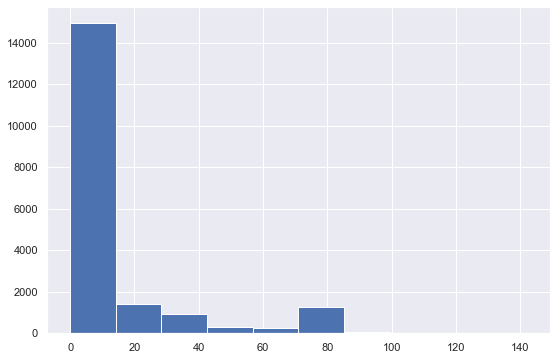

In [63]:
X[X.correct <= 150]['correct'].hist()

In [64]:
X[X.correct >= 40]['correct'].count()

2013

In [65]:
X.correct.quantile(0.95)

75.0

In [66]:
X.correct.quantile(0.896)

40.0

<b>Примерно 10% пользователей получили больше 40 баллов на курсе за первые два дня</b>

In [67]:
y = X.correct >= 40
y = y.apply(int)
y.head()

user_id
2     0
3     0
8     0
14    0
16    1
Name: correct, dtype: int64

In [68]:
y.shape

(19234,)

Применим алгоритм <b>Random forest</b>

In [69]:
rf = RandomForestClassifier()
parametrs = {'n_estimators': range(10, 51, 10),
            'max_depth': range(1, 13, 2),
            'min_samples_leaf': range(1, 8),
            'min_samples_split': range(2, 10, 2)}
grid_search = GridSearchCV(rf, param_grid=parametrs, cv=5, n_jobs=-1)

In [70]:
_ = grid_search.fit(X, y)

In [71]:
grid_search.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

In [72]:
best_estimator = grid_search.best_estimator_
best_estimator

RandomForestClassifier(max_depth=3, n_estimators=20)

In [73]:
y_predicted = grid_search.predict_proba(X_test)[:, 1]
y_predicted

array([0.00525891, 0.18507828, 0.04236177, ..., 0.00079533, 0.00079533,
       0.00079533])

In [74]:
result = pd.DataFrame(data={'user_id':X_test.index, 'is_gone':y_predicted})
result.head()

,user_id,is_gone
0,12,0.005259
1,13,0.185078
2,15,0.042362
3,21,0.122588
4,35,0.075856


In [75]:
result.to_csv('output.csv', index=False)

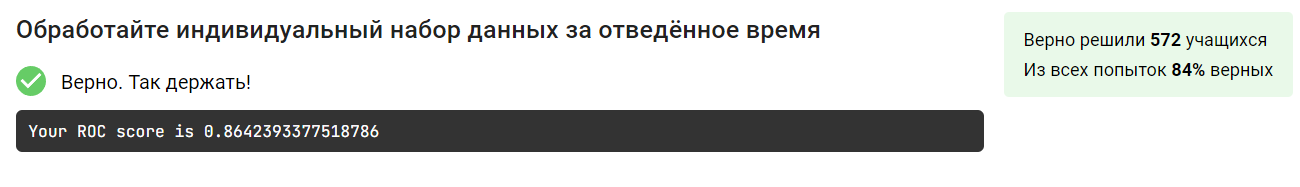